In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from termcolor import colored
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import csv
import numpy as np

Učitavamo naše podatke i ispisujemo prvih pet

In [2]:
df = pd.read_csv("../dataset/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Hoćemo da analiziramo bolje nase podatke , a iz ovoga možemo da pretpostavimo da nam je stroke ciljni atribut


In [3]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Ovde su nam predstavljeni samo numerički atributi i imamo ih 7, dok su ostalih 5 kategorički.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Osim što vidimo kog su tipa atributi, možemo primetiti da atribut bmi sandži nešto manje Non-Null vrednosti od drugih, tj možemo da pretpostavimo da sadrži null vrednosti, a sad ćemo to i da proverimo.

In [5]:
df.isna().any().any()

True

In [6]:
df.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

Ovde smo proverili i videli da bmi ima nedostajucih vrednosti

In [7]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
size_with_na = len(df)
size_without_na = len(df.dropna())

print(size_with_na , size_without_na , (size_without_na / len(df)) *100 )


5110 4909 96.0665362035225


I ako bi naš skup izgubio svega 4% podfka, ne bi smeli da ih odmah uklonimo jer su nam možda baš ti podaci od važni, a sada ćemo to i da proverimo

In [9]:
 print(sum(df['stroke'] == 1) , sum(df['stroke'] == 0))

249 4861


<AxesSubplot:>

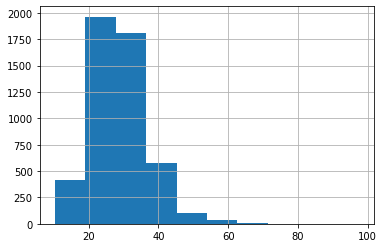

In [10]:
df['bmi'].hist()

In [11]:
df_without_bmi = df.dropna()
print(sum(df_without_bmi['stroke'] == 1))

209


Kako imamo mali broj vrednosti podfka za koji je vrednost stroke jedinica, ovih 40 vrednosti ne bi smeli da izgubimo, pa ćemo  iskoristiti neku drugu metodu za uklanjanje nedostajućih vrednosti


In [12]:
df['bmi'].fillna(df['bmi'].median(), inplace=True)

<AxesSubplot:>

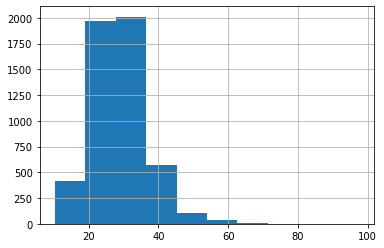

In [13]:
df['bmi'].hist()

In [14]:
df.isna().any().any()

False

Sada kada nemamo više nedostajućih vrednosti možemo nastaviti sa  detaljnijom analizom. Kada smo proveravali koliko podfka ima vrednost 1 za atribut stroke, videli smo da se odnos podfka dosta razlikuje , tj da imamo nebalansiranost a možemo to videti i grafički

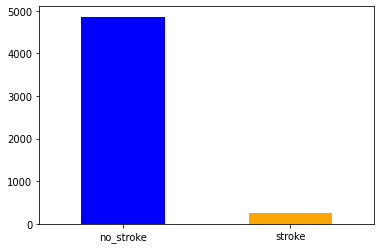

In [15]:
st_plot = df['stroke'].value_counts().plot(kind="bar",color=["blue","orange"], rot=0)
plt.xticks(ticks=[1,0], labels=["stroke", "no_stroke"]);
plt.savefig("unbalacneddata.jpg")

In [16]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [17]:
df.corr()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.003538,0.003550,-0.001296,0.001092,0.005555,0.006388
age,0.003538,1.000000,0.276398,0.263796,0.238171,0.324296,0.245257
hypertension,0.003550,0.276398,1.000000,0.108306,0.174474,0.158293,0.127904
heart_disease,-0.001296,0.263796,0.108306,1.000000,0.161857,0.036916,0.134914
avg_glucose_level,0.001092,0.238171,0.174474,0.161857,1.000000,0.166876,0.131945
bmi,0.005555,0.324296,0.158293,0.036916,0.166876,1.000000,0.036110
stroke,0.006388,0.245257,0.127904,0.134914,0.131945,0.036110,1.000000


In [18]:
df.drop(columns=['id'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


U tabeli zavisnoti smo videli da atribut id ne utiče na naš ciljni atribut ni 0.1 posto, a mogli smo da pretpostavimo to i sami , pa smo ovaj atribut izbacili. U ovoj tabeli vidimo koliko koji atribut utiče na ciljni ali i njihovu medjusobnu zavisnost. Ovde vidimo da će nam atribut age biti jedan od važnijih atrbiuta prilikom pravljenja našeg modela.

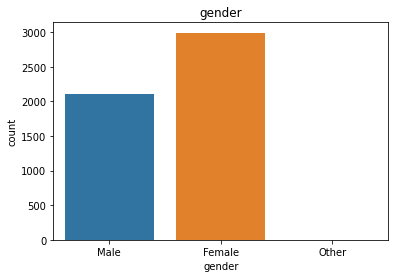

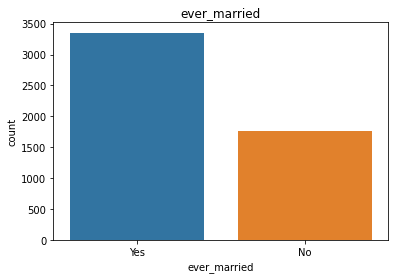

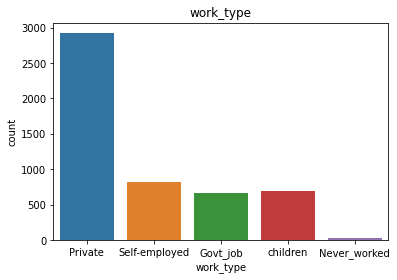

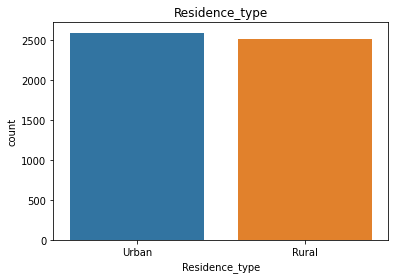

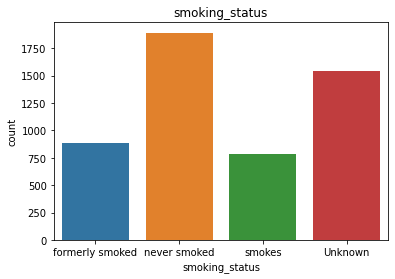

In [19]:
obj_attr = df.dtypes[df.dtypes == 'object'].index
obj_attr
for i in obj_attr:
    plt.figure()
    plt.title(i)
    sns.countplot(x=df[i])
    plt.show()

In [20]:
sum(df['gender'] == 'Other')

1

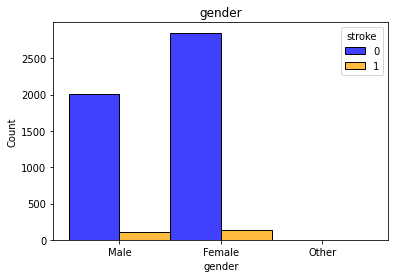

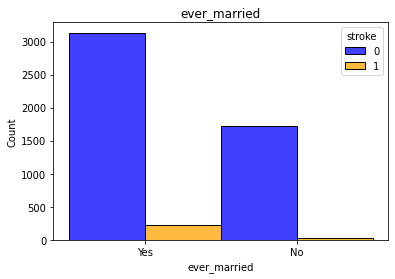

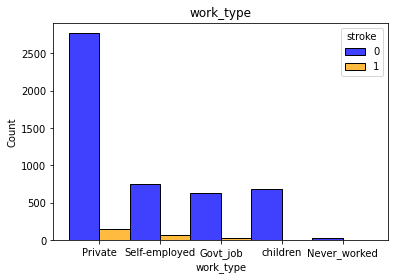

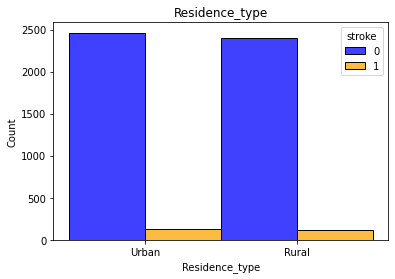

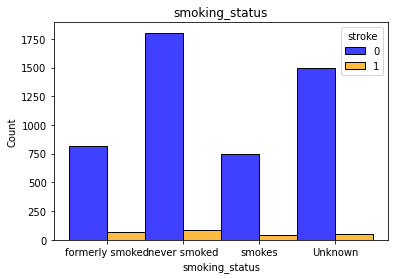

In [21]:

custom_palette = ['blue', 'orange']

    
obj_attr = df.dtypes[df.dtypes == 'object'].index
for i in obj_attr:
    plt.figure()
    plt.title(i)
    sns.histplot(data=df , x=df[i],hue='stroke', multiple="dodge", bins=5, palette=custom_palette)
    plt.savefig(f'zavisnost {i}.jpg')
    plt.show()
    
   

In [22]:

df.drop(df[df['gender'] == 'Other'].index, axis=0, inplace=True)

In [23]:
sum(df['work_type'] == 'Never_worked')

22

In [24]:
df['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [25]:
df.to_csv( 'data_apriori.csv', index=False )


Ispitali smo podatke koji nisu numerickog tipa i uklonili 'Other' iz 'gender' da nam ne bi smetao prilikom klasifikacije jer je rec o jednom podatku od 5110, sada cemo ispitati numericke i videti da li imamo autlajere

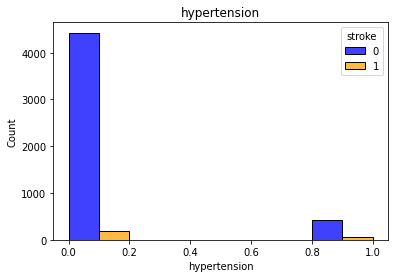

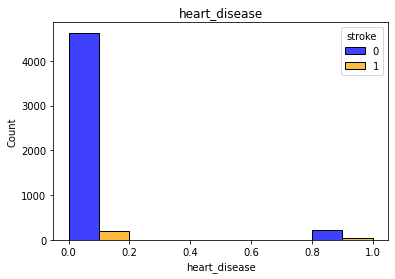

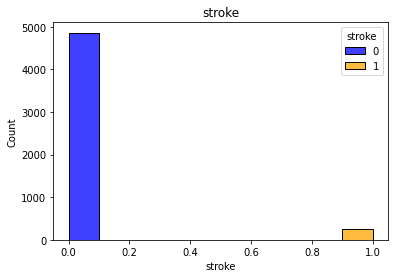

In [26]:
num_attr = df.dtypes[df.dtypes == 'int64'].index
for i in num_attr:
    plt.figure()
    plt.title(i)
    sns.histplot(data=df , x=df[i],hue='stroke', multiple="dodge", bins=5, palette=custom_palette)
    plt.savefig(f'zavisnost {i}.jpg')
    plt.show()

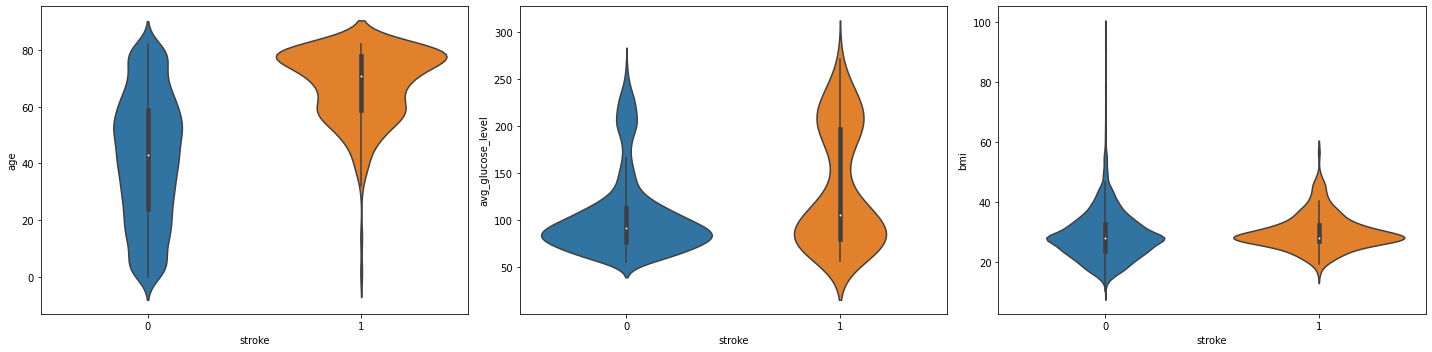

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
continuous_variables = ['age', 'avg_glucose_level', 'bmi']
for var, subplot in zip(continuous_variables, axs.flatten()):
    sns.violinplot(x=df['stroke'], y=df[var], ax=subplot)
    

plt.tight_layout()
plt.savefig(f'zavisnost {var}.jpg')
plt.show()

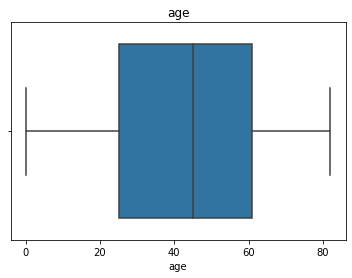

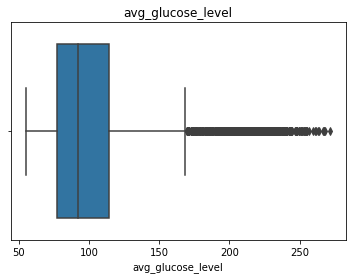

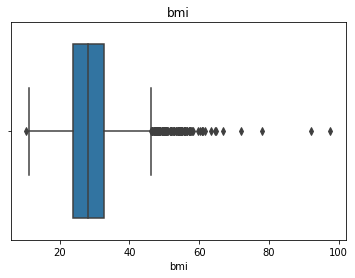

In [28]:
num_attr = df.dtypes[df.dtypes == 'float64'].index
for i in num_attr:
    plt.figure()
    plt.title(i)
    sns.boxplot(x=df[i])
    plt.savefig(f' autlajeri {i}.jpg')
    plt.show()

In [29]:
df['avg_glucose_level'].describe()

count    5109.000000
mean      106.140399
std        45.285004
min        55.120000
25%        77.240000
50%        91.880000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

In [30]:
df['bmi'].describe()

count    5109.000000
mean       28.863300
std         7.699785
min        10.300000
25%        23.800000
50%        28.100000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

In [31]:
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return ((column < lower_bound) | (column > upper_bound)).sum()

# Check for outliers in 'age', 'avg_glucose_level', and 'bmi'
outliers = {column: count_outliers(df[column]) for column in ['age', 'avg_glucose_level', 'bmi']}

outliers

{'age': 0, 'avg_glucose_level': 627, 'bmi': 126}

In [32]:
zero_or_negative_values = {column: (df[column] <= 0).sum() for column in ['avg_glucose_level', 'bmi']}

zero_or_negative_values

{'avg_glucose_level': 0, 'bmi': 0}

{'avg_glucose_level': 380, 'bmi': 88}


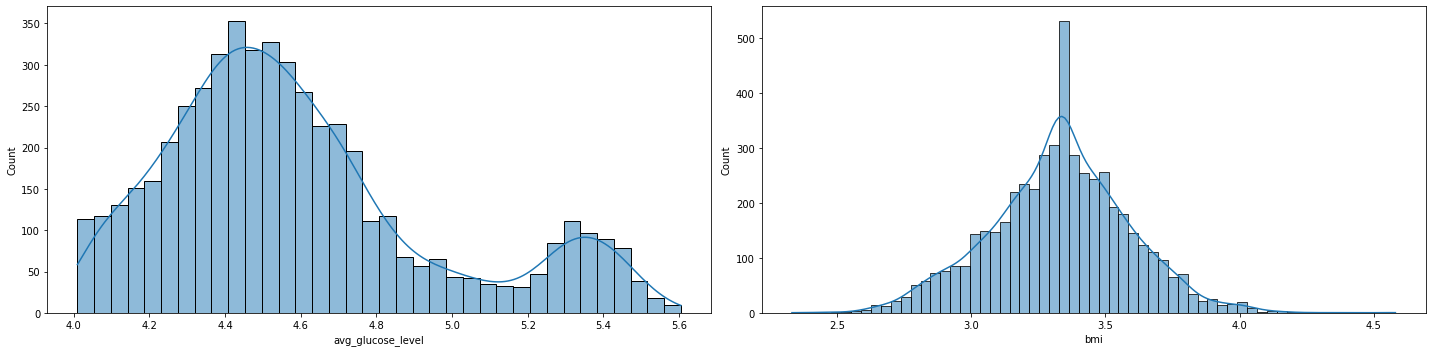

/home/marija/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/marija/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


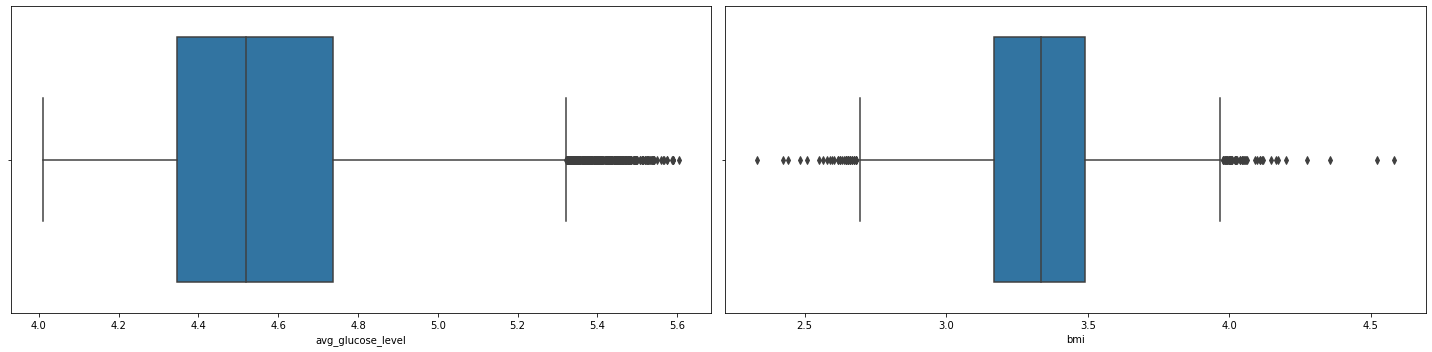

In [33]:
#ako imamo malo tacaka sa velikim vrednostima i dosta tacaka sa malim vrednostima.


df['avg_glucose_level'] = np.log(df['avg_glucose_level'])
df['bmi'] = np.log(df['bmi'])

# Check for outliers in 'avg_glucose_level' and 'bmi' after transformation
outliers_transformed = {column: count_outliers(df[column]) for column in ['avg_glucose_level', 'bmi']}

print(outliers_transformed)

# List of continuous variables
continuous_variables = ['avg_glucose_level', 'bmi']

# Plot the histograms for continuous variables
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for var, subplot in zip(continuous_variables, axs.flatten()):
    sns.histplot(df[var], kde=True, ax=subplot)

plt.tight_layout()
plt.show()

# Plot the boxplots for continuous variables
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for var, subplot in zip(continuous_variables, axs.flatten()):
    sns.boxplot(df[var], ax=subplot)

plt.tight_layout()
plt.show()

Ovde smo videli da bmi ima autlajere  i uklonili smo ih, sada mozemo ici dalje


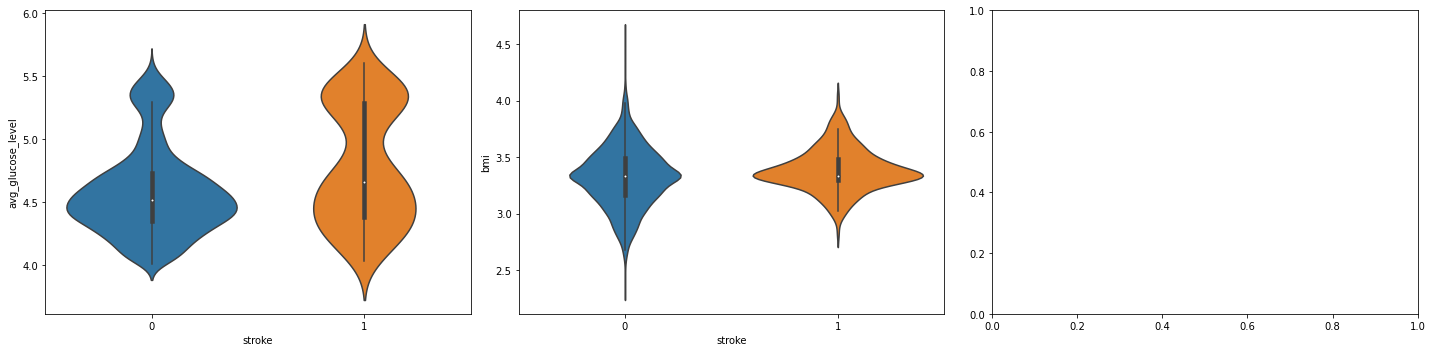

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
continuous_variables = [ 'avg_glucose_level', 'bmi']
for var, subplot in zip(continuous_variables, axs.flatten()):
    sns.violinplot(x=df['stroke'], y=df[var], ax=subplot)

plt.tight_layout()
plt.show()

In [35]:
#predvaramo objekte u int64
obj_attr = df.dtypes[df.dtypes == 'object'].index
for i in  obj_attr:
    osobine = df[i].unique()
    
    for j,k in enumerate(osobine):
        
        df[i].replace(k, j, inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int64  
 5   work_type          5109 non-null   int64  
 6   Residence_type     5109 non-null   int64  
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   int64  
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 608.0 KB


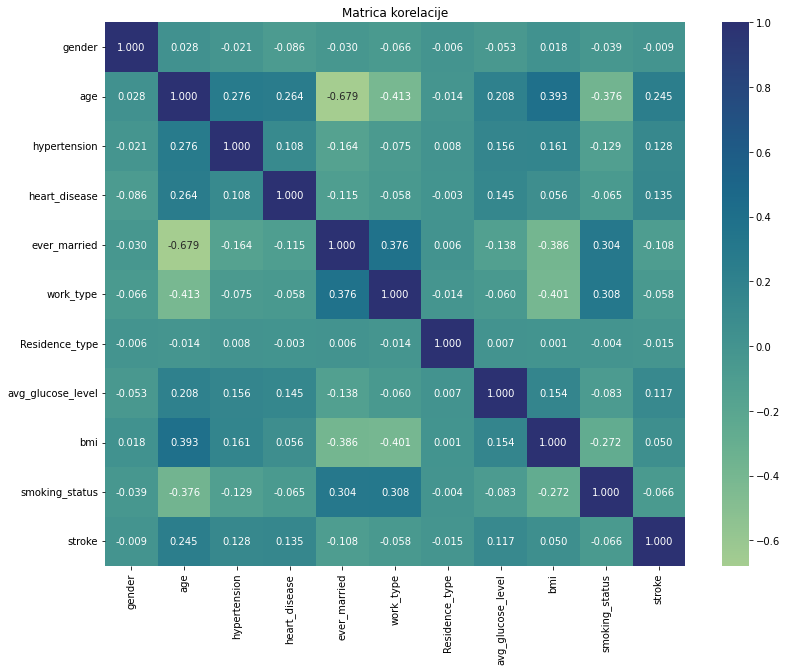

In [37]:
plt.figure(figsize=(13,10))

sns.heatmap(df.corr(), annot=True,  cmap="crest", fmt='.3f',linecolor='yellow')
plt.title('Matrica korelacije')
plt.savefig(f'heatmap.jpg')

Sada kada smo pretvorili kategoricke podatke u int64 i izvrsili standardizajicu mozemo da podalimo na X i Y i da resimo problem nebalansiranosti

In [38]:
X = df.drop(columns=['stroke'])
y = df['stroke']


In [39]:
X.to_csv( 'X_preprocessed1.csv', index=False )

In [40]:
y.to_csv( 'Y_preprocessed1.csv', index=False )
